# Client Command Assessment

The purpose of this notebook is to analyze the given datasets and find ["who is most likely to purchase a vehicle."](https://github.com/SummitResources/data_engineer_technical_assessment/blob/master/README.md)

The time limit is two hours. Start time is:
**8:10 PM Jan 30, 2020**

I will begin by reading in the necessary libraries and exploring the data. After an initial preview of the csv files, these are my initial observations:
* It seems as though several of the included files are repetitions of the same schema (`'online_behavior_0'`, `'online_behavior_1'`, etc.).
* These csv files have three columns: 
    * `'activity_time'` - a timestamp
    * `'list_id'` - an activity code
    * `'email'` - an encoded personal email address
* `'emails.csv'` contains personal identifiers:
    * `'email'` - an encoded personal email address
    * `'first_name'`, `'last_name'`
    * `'address'`, `'city'`, `'state'`, `'zip'`, `'zip4'` - address information
* `'online_behavior_taxonomy.csv'` contains information on the activity codes:
    * `'list_id'` - the same code from the `'online_behavior'` files
    * `'list_name'` - a string with information about the `'list_id'`
    
After this analysis, it seems the best approach to combine these datasets into useful information would be:
* Clean and remove unnecessary data from the taxonomy file
* Split the `'list_name'` field into useful categories (make, model, etc.)
* Concatenate and dedupe the `'online_behavior'` csv files
* Match each record to a `'list_name'` and name/address
* Match each record to a taxonomy record
* Group by email address and find summary statistics for each individual
* Use summary statistics to rank best prospects
* If time allows, use geographical email to break down into local area lists

In [2]:
# importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

## Cleaning Taxonomy File

In [5]:
# reading in taxonomy file
tax = pd.read_csv('online_behavior_taxonomy.csv')
tax.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 572 entries, 0 to 571
Data columns (total 2 columns):
list_id      572 non-null object
list_name    572 non-null object
dtypes: object(2)
memory usage: 9.0+ KB


In [7]:
# exploring taxonomy file
tax.head(20)

,list_id,list_name
0,105cg9y8eueze,Client Command Target Lists - 2326
1,106bv2r2p8l3zk,Types > Trucks
2,106heh3nd8keef,Client Command Target Lists - 2427
3,106lkqb3g8sp,Makes > Nissan > GT-R
4,10d5n9y2mknalh,Contexts > Cargo Space
5,10e1vm12mfrtvy,Makes > Infiniti > QX80
6,10mq976nd8i29s,Client Command Target Lists - 2333
7,10ni8sk1swr8do0i,Client Command Target Lists - 2310
8,10ooas56hoc6ckx,Client Command Target Lists - 321
9,10pa6526hoc92f0,Client Command Target Lists - 1785


In [8]:
# exploring unique values in dataset
print(len(tax['list_name'].unique()))

571


This list consists of 572 codes for web activities. Only one seems to be duplicated.

Values containing "Client Command Target Lists" do not help in this analysis, since their meaning is unknown. The other data, however, is descriptive enough to help us determine what make, model, price range, and 'context' the buyers are looking for.

I will remove the unnecessary data from this index, and use the index to remove unnecessary records from the main datasets.

In [56]:
# removing all "Client Command Target Lists" records
tax_clean = tax[~tax.list_name.str.contains("Client Command Target")]
# remove duplicates from list
tax_clean = tax_clean.drop_duplicates()
print(len(tax_clean))

341


This eliminated 230 values from the list.

Next, I will split the `'list_name'` category into separate columns to help create more useable column data. I will split using the " > " between each text value. This should leave separate word/phrases without spaces.

**Note:** there are some values which are not make or model information. We will keep these in the Make/Model category for now and move them to new columns in the next step.

In [57]:
# creating new columns and splitting list name
tax_clean[['category','make','model']] = tax_clean['list_name'].str.split(' > ', expand=True)
# dropping old column data
tax_clean.drop(['list_name'], axis=1, inplace=True)
tax_clean.head(20)

,list_id,category,make,model
1,106bv2r2p8l3zk,Types,Trucks,None
3,106lkqb3g8sp,Makes,Nissan,GT-R
4,10d5n9y2mknalh,Contexts,Cargo Space,None
5,10e1vm12mfrtvy,Makes,Infiniti,QX80
10,10rod50y6v6b,Makes,Chevrolet,Impala
11,10s5ems2p7ifqi,Makes,Chevrolet,None
14,11250tl2mzlfv3,Makes,GMC,Sierra
15,112aj2xyv8a6,Auto In-Market,"Under $15,000",None
17,117s9e13ic2w,Auto In-Market,"Under $10,000",None
18,11901teqph1ptq,Makes,Audi,RS 4


I now need to clean up the `'make'` column, since it has other non-make values. For any row whose category is not "Makes," I will move the "Make" value to a new column.

In [58]:
# creating a new column with null values
tax_clean['descriptor'] = np.NaN

# creating a mask to check for non-make values
tax_clean.loc[tax_clean['category']!='Makes', 'descriptor'] = tax_clean['make']
# removing non-make values from make column
tax_clean.loc[tax_clean['category']!='Makes', 'make'] = np.NaN

In [61]:
tax_clean.head(20)

,list_id,category,make,model,descriptor
1,106bv2r2p8l3zk,Types,NaN,None,Trucks
3,106lkqb3g8sp,Makes,Nissan,GT-R,NaN
4,10d5n9y2mknalh,Contexts,NaN,None,Cargo Space
5,10e1vm12mfrtvy,Makes,Infiniti,QX80,NaN
10,10rod50y6v6b,Makes,Chevrolet,Impala,NaN
11,10s5ems2p7ifqi,Makes,Chevrolet,None,NaN
14,11250tl2mzlfv3,Makes,GMC,Sierra,NaN
15,112aj2xyv8a6,Auto In-Market,NaN,None,"Under $15,000"
17,117s9e13ic2w,Auto In-Market,NaN,None,"Under $10,000"
18,11901teqph1ptq,Makes,Audi,RS 4,NaN


It looks as though this data is now clean and ready to be combined with the `'online_behavior'` csv files.

## Concatenate and dedupe online_behavior files

In [62]:
# read files into dataframes
ob_0 = pd.read_csv('online_behavior_0.csv')
ob_1 = pd.read_csv('online_behavior_1.csv')
ob_2 = pd.read_csv('online_behavior_2.csv')
ob_3 = pd.read_csv('online_behavior_3.csv')
ob_4 = pd.read_csv('online_behavior_4.csv')
ob_5 = pd.read_csv('online_behavior_5.csv')
# note - if time permitted, this could be standardized
# into a function with increasing numerical values

In [64]:
# inspecting dataframes to ensure continuity
ob_0.head()

,activity_time,list_id,email
0,2019-08-01 00:00:22,xoflnm7iolq5tm,001669919a063084c105e19cf801c2d3
1,2019-08-01 00:00:22,106bv2r2p8l3zk,001669919a063084c105e19cf801c2d3
2,2019-08-01 00:00:22,fm509c2p77ptf,001669919a063084c105e19cf801c2d3
3,2019-08-01 00:00:22,t7eaf82oa2h6v,001669919a063084c105e19cf801c2d3
4,2019-08-01 00:00:22,9zoquqsnda6r,001669919a063084c105e19cf801c2d3


In [65]:
ob_1.head()

,activity_time,list_id,email
0,2019-08-06 16:16:58,ddzv5g2mwgykc,00065281c45561088a4fcc584c2be827
1,2019-08-06 16:16:58,15w0v6z04bk,00065281c45561088a4fcc584c2be827
2,2019-08-06 16:16:58,1opy6d9phl8v,00065281c45561088a4fcc584c2be827
3,2019-08-06 16:16:58,xeqtfdz0dag,00065281c45561088a4fcc584c2be827
4,2019-08-06 16:16:58,5xpt142m761n2,00065281c45561088a4fcc584c2be827


In [66]:
ob_2.head()

,activity_time,list_id,email
0,2019-08-12 06:59:20,fm509c2p77ptf,0018da65379a9b5944d6217a21e05e5a
1,2019-08-12 06:59:24,fm509c2p77ptf,0018da65379a9b5944d6217a21e05e5a
2,2019-08-12 06:59:36,fm509c2p77ptf,0018da65379a9b5944d6217a21e05e5a
3,2019-08-12 07:00:17,90cavt9os967,001d26178c2fa3040de9bab3b0cacfec
4,2019-08-12 07:00:17,xeqtfdz0dag,001d26178c2fa3040de9bab3b0cacfec


In [67]:
ob_3.head()

,activity_time,list_id,email
0,2019-08-16 03:32:49,r1ai5j9on1zq,001a430dfc00c9c30f490e4f29b12338
1,2019-08-16 03:32:49,1q0d2uyzkdp,001a430dfc00c9c30f490e4f29b12338
2,2019-08-16 03:32:49,t7eaf82oa2h6v,001a430dfc00c9c30f490e4f29b12338
3,2019-08-16 03:32:49,muxush2mt6n6k,001a430dfc00c9c30f490e4f29b12338
4,2019-08-16 03:32:49,15w0v6z04bk,001a430dfc00c9c30f490e4f29b12338


In [68]:
ob_4.head()

,activity_time,list_id,email
0,2019-08-21 14:04:44,66hid4qcyhb1m,0005822a48051903dc9dd2d9c505c4eb
1,2019-08-21 14:04:44,11izt352oh37k4,0005822a48051903dc9dd2d9c505c4eb
2,2019-08-21 14:04:44,15w0v6z04bk,0005822a48051903dc9dd2d9c505c4eb
3,2019-08-21 14:04:44,jh7i2hqssytyr,0005822a48051903dc9dd2d9c505c4eb
4,2019-08-21 14:04:44,mj2s1j9pubmr,0005822a48051903dc9dd2d9c505c4eb


In [69]:
ob_5.head()

,activity_time,list_id,email
0,2019-08-26 18:42:17,sy3y1g98ja4w,000363cef451da4d398f541b7c699ea9
1,2019-08-26 18:42:17,se6p012plppsw,000363cef451da4d398f541b7c699ea9
2,2019-08-26 18:42:17,xeqtfdz0dag,000363cef451da4d398f541b7c699ea9
3,2019-08-26 18:42:17,o6goc4vv6rd,000363cef451da4d398f541b7c699ea9
4,2019-08-26 18:42:17,nd20pt2mqam1x,000363cef451da4d398f541b7c699ea9


All five dataframes have the same structure and can be concatenated together.

In [70]:
# concatenating dataframes into one master dataframe
online_behavior = pd.concat([ob_0, ob_1, ob_2, ob_3, ob_4, ob_5], ignore_index=True)
online_behavior.describe()

,activity_time,list_id,email
count,1325548,1325548,1325548
unique,309717,1755,10000
top,2019-08-18 20:01:36,fm509c2p77ptf,0007a079a8aa5d6297d79c449df36a65
freq,327,147258,28395


In [72]:
# remove duplicates from master dataframe
online_behavior = online_behavior.drop_duplicates()

In [73]:
online_behavior.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1324600 entries, 0 to 1325547
Data columns (total 3 columns):
activity_time    1324600 non-null object
list_id          1324600 non-null object
email            1324600 non-null object
dtypes: object(3)
memory usage: 40.4+ MB


The final master dataframe has over 1 million rows, none of which are null.

## Matching records to name and address

We can now match rows in the master dataframe to names and addresses in the `'emails'` file, using email as a primary key. To do this, we will use a merge, bringing data from the `'emails'` file in to match rows in the master dataframe.

In [75]:
# reading in emails file
emails = pd.read_csv('emails.csv')
emails.head()

,email,first_name,last_name,address,city,state,zip,zip4
0,0000d3deae38e7c8ae876d0a3b07c059,0238456507450c337e44769fa98f8753,08a29cf8feb5de58d26112df3ae076ff,613 HICKORY DR,WAYLAND,MI,49348.0,1391.0
1,001ff8ad2a6c9f9e2b5625f46b039927,3323d2fccb2ccb3f12834d702cb14636,fbd59899ae0261200112603a260b9cfc,5103 GEORGINE DR,IMPERIAL,MO,63052.0,4028.0
2,00174604b3cc988095f26c871280ce43,c1504a805bd0eced6bfc30111791d49b,bf5ee79ff7df423c29e5317519af6f36,1214 ARMACOST RD,SAN DIEGO,CA,92114.0,3307.0
3,0010b8b2914af4ed4d861b25b0897df9,f4ae860f82bf44d56ad5286291493954,c935a4e21742b5a03a15b05834e2d82c,5011 RIME VLG,BIRMINGHAM,AL,35216.0,6456.0
4,001091729889c8b6b39baba57c91f289,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [94]:
emails.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9623 entries, 0 to 9622
Data columns (total 8 columns):
email         9623 non-null object
first_name    6300 non-null object
last_name     6292 non-null object
address       6305 non-null object
city          6294 non-null object
state         6287 non-null object
zip           6292 non-null float64
zip4          5759 non-null float64
dtypes: float64(2), object(6)
memory usage: 601.5+ KB


In [90]:
ob_with_names = online_behavior.merge(emails, how='left', on="email")

In [92]:
ob_with_names.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1324600 entries, 0 to 1324599
Data columns (total 10 columns):
activity_time    1324600 non-null object
list_id          1324600 non-null object
email            1324600 non-null object
first_name       496271 non-null object
last_name        496591 non-null object
address          497594 non-null object
city             497594 non-null object
state            497594 non-null object
zip              497536 non-null float64
zip4             473391 non-null float64
dtypes: float64(2), object(8)
memory usage: 111.2+ MB


In [95]:
ob_with_names.head()

,activity_time,list_id,email,first_name,last_name,address,city,state,zip,zip4
0,2019-08-01 00:00:22,xoflnm7iolq5tm,001669919a063084c105e19cf801c2d3,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2019-08-01 00:00:22,106bv2r2p8l3zk,001669919a063084c105e19cf801c2d3,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2019-08-01 00:00:22,fm509c2p77ptf,001669919a063084c105e19cf801c2d3,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2019-08-01 00:00:22,t7eaf82oa2h6v,001669919a063084c105e19cf801c2d3,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2019-08-01 00:00:22,9zoquqsnda6r,001669919a063084c105e19cf801c2d3,NaN,NaN,NaN,NaN,NaN,NaN,NaN


It seems as though many of the records in the main dataframe do not have a match in the `'emails'` file. These will be "unknown" individuals, identified only by email address and behavior.

## Match each record to a taxonomy record

Now, I need to bring in the web behavior to each record, merging in the `'tax_clean'` dataframe from above. The method will be the same as the last merge.

In [122]:
# merging taxonomy data into master dataframe
master = ob_with_names.merge(tax_clean, how='left', on="list_id")

In [123]:
master.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1334175 entries, 0 to 1334174
Data columns (total 14 columns):
activity_time    1334175 non-null object
list_id          1334175 non-null object
email            1334175 non-null object
first_name       499881 non-null object
last_name        500213 non-null object
address          501218 non-null object
city             501218 non-null object
state            501218 non-null object
zip              501153 non-null float64
zip4             476848 non-null float64
category         988412 non-null object
make             663997 non-null object
model            153693 non-null object
descriptor       324415 non-null object
dtypes: float64(2), object(12)
memory usage: 152.7+ MB


Remember from above, we removed all values which did not have a useable `'category'` value. We can now eliminate all rows whose values for `'category'` is null.

In [124]:
# dropping all rows with null values in category
master = master.dropna(axis=0, subset=['category'])
master.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 988412 entries, 1 to 1334174
Data columns (total 14 columns):
activity_time    988412 non-null object
list_id          988412 non-null object
email            988412 non-null object
first_name       368149 non-null object
last_name        368256 non-null object
address          369188 non-null object
city             369188 non-null object
state            369188 non-null object
zip              369132 non-null float64
zip4             351206 non-null float64
category         988412 non-null object
make             663997 non-null object
model            153693 non-null object
descriptor       324415 non-null object
dtypes: float64(2), object(12)
memory usage: 113.1+ MB


Now the lengths of the `'email'` and `'category'` columns match, so there are no values with unuseable `'list_id'` data.

## Get number of occurrences by email

Now I can groupby `'email'` and count the number of entries for each unique person in the dataframe. This could be a good indicator of desire to purchase.

In [125]:
# creating groupby object for summary count
master_group = master.groupby('email').agg('count')

In [126]:
master_group.head()

,activity_time,list_id,first_name,last_name,address,city,state,zip,zip4,category,make,model,descriptor
email,,,,,,,,,,,,,
00000000000000000000000000000000,111,111,0,0,0,0,0,0,0,111,78,3,33
0000000e38b6ef28b62358f745724f1d,11,11,11,11,11,11,11,11,0,11,10,3,1
0000004302fec7a5ef011008c0fd54ae,5,5,0,0,0,0,0,0,0,5,3,1,2
0000018cc47919194c8a10848baeb89c,33,33,0,0,0,0,0,0,0,33,21,6,12
000001c1df97af55b931f84f8e3aa65d,29,29,29,29,29,29,29,29,29,29,20,2,9


There is obviously a problematic `'email'` value, with zeros for an email value. These rows should be dropped from the master dataframe, and the groupby recalculated.

In [146]:
# removing bad values from master dataframe
master = master[master.email != '00000000000000000000000000000000']

# recreating groupby object for summary count
master_group = master.groupby('email').agg('count')

In [147]:
master_group.sort_values(by='list_id', ascending=False, inplace=True)
master_group.head()

,activity_time,list_id,first_name,last_name,address,city,state,zip,zip4,category,make,model,descriptor
email,,,,,,,,,,,,,
0007a079a8aa5d6297d79c449df36a65,22806,22806,22806,22806,22806,22806,22806,22806,22806,22806,15672,4445,7134
0006571a39da444e803325328c60b57f,7345,7345,0,0,0,0,0,0,0,7345,5575,1288,1770
0003e6e6f5d8e4c93e639cad1ac3fb2f,4736,4736,0,0,0,0,0,0,0,4736,3249,867,1487
000eaf9de12bdfd55bd3140365874bf6,4715,4715,0,0,0,0,0,0,0,4715,3234,706,1481
000cd565974ffb661276a99d40ca9004,4565,4565,4565,4565,4565,4565,4565,4565,4565,4565,3248,705,1317


In [148]:
# exploring summary statistics for the count of individuals
master_group['list_id'].describe()

count     9782.000000
mean       101.032611
std        347.979307
min          1.000000
25%          9.000000
50%         25.000000
75%         81.000000
max      22806.000000
Name: list_id, dtype: float64

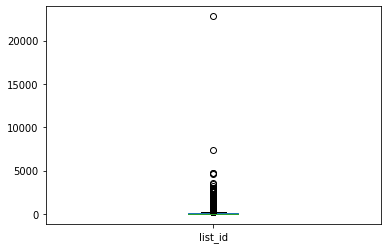

In [149]:
master_group['list_id'].plot.box()

The top instance in this grouping seems suspect, and may be an outlier which needs to be removed. But it is possible this person is not an outlier, so we will keep it in the master dataframe and continue to explore.

## List One: most active prospects

Using this groupby dataframe, we can create a new list of prospects sorted by number of instances. I will create this sorted dataframe, which could eventually be exported to a new file or database table.

In [150]:
# creating new dataframe with only email and count columns
# saving index of master_group to new column
master_group.reset_index(inplace=True)
# list of columns to keep
cols = ['email', 'list_id']
most_active = master_group[cols]

In [151]:
# merging in name and address data
most_active_final = most_active.merge(emails, how='left', on="email")
most_active_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9782 entries, 0 to 9781
Data columns (total 9 columns):
email         9782 non-null object
list_id       9782 non-null int64
first_name    3517 non-null object
last_name     3512 non-null object
address       3521 non-null object
city          3521 non-null object
state         3521 non-null object
zip           3520 non-null float64
zip4          3266 non-null float64
dtypes: float64(2), int64(1), object(6)
memory usage: 764.2+ KB


This new dataframe is available with a listing of the most active users, including geographical data. This could easily be broken down into geographical location by state or zip code, for specific dealerships.

# Creating make and car-specific counts

Now, I can return to the master datafame and one-hot encode the `'category'`, `'make'` and `'model'` columns. By doing so, it will allow me to perform a new groupby with a sum of each column, showing the interest of each person in particular vehicles.

Once this is done, I will merge this back in with the dataframe above, to create a record for each individual with activity level and relative interest in each categorymake, model and descriptor.

Because I will eventually merge this back in, I can delete the duplicate columns to keep the dataframe as simple as possible.

In [152]:
# refamiliarizing myself with master
master.head()

,activity_time,list_id,email,first_name,last_name,address,city,state,zip,zip4,category,make,model,descriptor
1,2019-08-01 00:00:22,106bv2r2p8l3zk,001669919a063084c105e19cf801c2d3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Types,NaN,None,Trucks
2,2019-08-01 00:00:22,fm509c2p77ptf,001669919a063084c105e19cf801c2d3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Makes,"Dodge, Chrysler, Jeep",None,NaN
3,2019-08-01 00:00:22,t7eaf82oa2h6v,001669919a063084c105e19cf801c2d3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Makes,Ford,None,NaN
4,2019-08-01 00:00:22,9zoquqsnda6r,001669919a063084c105e19cf801c2d3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Makes,Nissan,None,NaN
5,2019-08-01 00:00:22,14smgkj3hv5s,001669919a063084c105e19cf801c2d3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Journey,NaN,None,News & Reviews


In [153]:
# list of columns to keep
cols = ['activity_time','email','category','make','model','descriptor']
# keeping only these columns
master_detail = master[cols]

In [157]:
# creating list of columns to get dummies
dummy_cols = ['make','model','descriptor']
# creating dummy valus
master_detail_dummies = pd.get_dummies(master_detail[dummy_cols])

In [159]:
# creating dataframe with unused columns to merge
cols = ['activity_time', 'email']
master_emails = master[cols]
# concatenating two dataframes to include email information
master_info = pd.concat([master_emails, master_detail_dummies], axis=1)

In [160]:
master_info.head()

,activity_time,email,make_Acura,make_Alfa Romeo,make_Aston Martin,make_Audi,make_BMW,make_BMW 2,make_BMW 3,make_Bentley,...,descriptor_SUVs/Crossovers,descriptor_Safety,descriptor_Sedans/Coupes,descriptor_Trucks,"descriptor_Under $10,000","descriptor_Under $20,000","descriptor_Under $5,000",descriptor_Used Cars,descriptor_Vans/Minivans,descriptor_Websites
1,2019-08-01 00:00:22,001669919a063084c105e19cf801c2d3,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
2,2019-08-01 00:00:22,001669919a063084c105e19cf801c2d3,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,2019-08-01 00:00:22,001669919a063084c105e19cf801c2d3,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2019-08-01 00:00:22,001669919a063084c105e19cf801c2d3,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,2019-08-01 00:00:22,001669919a063084c105e19cf801c2d3,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


We now have information for each unique instance across numerous makes, models, and categories. If we now groupby email and aggregate by sum, we will get a value for each individual's interest level in these variables.

In [161]:
# creating groupby object grouping by email
master_info_agg = master_info.groupby('email').agg('sum')

Now, I can merge this info with aggregate sums for interest level with the `'most_active_final'` dataframe to create a final dataframe that contains useable info about prospect behavior.

In [164]:
# merging both into final dataframe
prospect_info = most_active_final.merge(master_info_agg, how='left', on="email")

In [169]:
# renaming list_id column to represent activity
prospect_info = prospect_info.rename(columns={'list_id': 'engagements'})

In [170]:
prospect_info.describe()

,engagements,zip,zip4,make_Acura,make_Alfa Romeo,make_Aston Martin,make_Audi,make_BMW,make_BMW 2,make_BMW 3,...,descriptor_SUVs/Crossovers,descriptor_Safety,descriptor_Sedans/Coupes,descriptor_Trucks,"descriptor_Under $10,000","descriptor_Under $20,000","descriptor_Under $5,000",descriptor_Used Cars,descriptor_Vans/Minivans,descriptor_Websites
count,9782.000000,3520.000000,3266.000000,9782.000000,9782.000000,9782.000000,9782.000000,9782.000000,9782.000000,9782.000000,...,9782.000000,9782.000000,9782.000000,9782.000000,9782.000000,9782.000000,9782.000000,9782.000000,9782.000000,9782.000000
mean,101.032611,50243.326136,4346.500000,0.559497,0.277755,0.686465,0.556941,0.268248,0.041914,0.101002,...,3.553363,1.588939,1.104580,3.959109,0.000511,0.001125,0.003987,0.091699,0.831936,1.069209
std,347.979307,29658.753683,2638.414606,5.804317,2.054277,5.908630,5.212211,2.179130,0.754011,1.093624,...,13.939723,7.240025,8.830059,15.784109,0.050554,0.078964,0.179983,0.818253,7.402557,7.203954
min,1.000000,1002.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,9.000000,26804.750000,2170.750000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,25.000000,47123.500000,3773.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,81.000000,77413.500000,6145.250000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,3.000000,1.000000,0.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,22806.000000,99901.000000,9897.000000,376.000000,52.000000,184.000000,316.000000,102.000000,43.000000,48.000000,...,603.000000,276.000000,706.000000,729.000000,5.000000,6.000000,12.000000,35.000000,353.000000,367.000000


In [171]:
prospect_info.head()

,email,engagements,first_name,last_name,address,city,state,zip,zip4,make_Acura,...,descriptor_SUVs/Crossovers,descriptor_Safety,descriptor_Sedans/Coupes,descriptor_Trucks,"descriptor_Under $10,000","descriptor_Under $20,000","descriptor_Under $5,000",descriptor_Used Cars,descriptor_Vans/Minivans,descriptor_Websites
0,0007a079a8aa5d6297d79c449df36a65,22806,c054805353e791b21fd3cd89f61cdf97,ce443f372fc03077bc323b42a158f52f,27 LORD RD,TEMPLETON,MA,1468.0,1454.0,128.0,...,603.0,276.0,271.0,729.0,0.0,0.0,0.0,17.0,158.0,316.0
1,0006571a39da444e803325328c60b57f,7345,NaN,NaN,NaN,NaN,NaN,NaN,NaN,310.0,...,144.0,193.0,69.0,130.0,0.0,0.0,5.0,4.0,33.0,63.0
2,0003e6e6f5d8e4c93e639cad1ac3fb2f,4736,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.0,...,167.0,75.0,56.0,140.0,0.0,0.0,0.0,2.0,38.0,45.0
3,000eaf9de12bdfd55bd3140365874bf6,4715,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,353.0,367.0
4,000cd565974ffb661276a99d40ca9004,4565,5f392165301cd8989a84699b91029d6b,4f346cf562eeb15eb1c1e771b654e6d6,15681 S LELAND RD,BEAVERCREEK,OR,97004.0,7650.0,22.0,...,202.0,63.0,22.0,144.0,0.0,0.0,0.0,0.0,83.0,41.0


In [172]:
# Saving this prospect dataframe to a file for future exploration
prospect_info.to_csv('prospect_info.csv')

# Results

The result of this project is a dataset with unified data on user behavior. To use this file, a dealer could filter based on geographical area, sort by number of engagements overall, and then drill down to the number of engagements based on make, model, or other descriptors of interest.

Finish time is: **10:11 PM Jan 30, 2020**